In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
X = pd.read_csv('../processed_data/X_processed.csv')
y = pd.read_csv('../processed_data/y_processed.csv')
X_exp = X.copy()
y = y.squeeze()
X_exp.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban,Total_Income,LoanToIncomeRatio
0,1,0,1,0,8.674197,0.000000,4.859812,360.0,1.0,False,False,False,False,True,8.674197,0.021648
1,1,1,1,0,8.430327,7.319202,4.859812,360.0,1.0,True,False,False,False,False,8.714732,0.020797
2,1,1,1,1,8.006701,0.000000,4.204693,360.0,1.0,False,False,False,False,True,8.006701,0.021761
3,1,1,0,0,7.857094,7.765993,4.795791,360.0,1.0,False,False,False,False,True,8.505525,0.023996
4,1,0,1,0,8.699681,0.000000,4.955827,360.0,1.0,False,False,False,False,True,8.699681,0.023228


In [2]:
X_exp['Total_Income'] = X_exp['ApplicantIncome'] + X_exp['CoapplicantIncome']
X_exp['LoanToIncomeRatio'] = X_exp['LoanAmount'] / (X_exp['Total_Income'] + 1e-5)  # prevent div by zero

print(X_exp.shape)
print(y.shape)


(614, 16)
(614,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_exp)



In [4]:
X_train_exp, X_test_exp, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


model_exp = LogisticRegression(max_iter=1000)
model_exp.fit(X_train_exp, y_train)


LogisticRegression(max_iter=1000)

In [5]:
print("\n📊 Logistic Regression Evaluation:")
y_pred = model_exp.predict(X_test_exp)

# 📊 Evaluate model performance
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))

# 🧩 Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred , labels = [ 1 , 0 ]))

# 📝 Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



📊 Logistic Regression Evaluation:
Accuracy: 0.8537
Precision: 0.8317
Recall: 0.9882
F1 Score: 0.9032

Confusion Matrix:
[[84  1]
 [17 21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



In [6]:
f1_scores_exp = cross_val_score(model_exp, X_train_exp, y_train, cv=5, scoring='f1')
print("\n Logistic Regression F1 CV scores:", f1_scores_exp)
print("Mean F1 Score (Logistic):", round(f1_scores_exp.mean(), 4))
print("Std Dev (Logistic):", round(f1_scores_exp.std(), 4))


 Logistic Regression F1 CV scores: [0.86666667 0.87581699 0.87248322 0.8627451  0.8627451 ]
Mean F1 Score (Logistic): 0.8681
Std Dev (Logistic): 0.0053


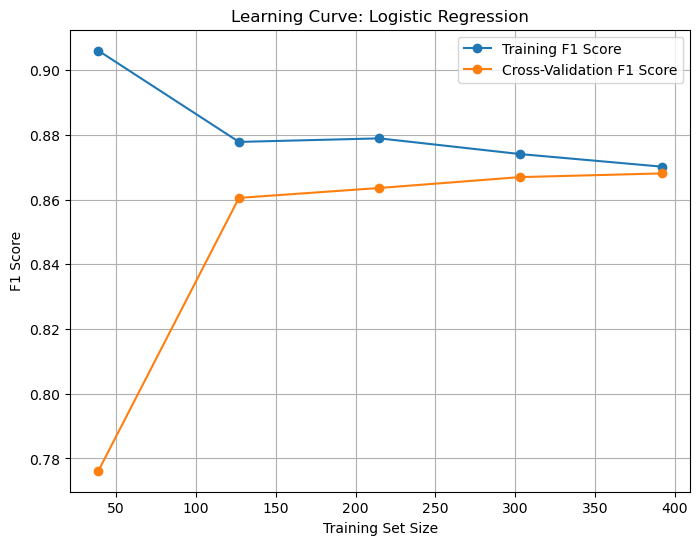

In [7]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
def plot_learning_curve(model, model_name, X_train_exp, y_train):
    train_sizes, train_scores, cv_scores = learning_curve(
        model, X_train_exp, y_train, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True,
        random_state=42
    )

    train_scores_mean = train_scores.mean(axis=1)
    cv_scores_mean = cv_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training F1 Score")
    plt.plot(train_sizes, cv_scores_mean, 'o-', label="Cross-Validation F1 Score")
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(model_exp, "Logistic Regression", X_train_exp, y_train)

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'penalty': [ 'l1' , 'l2'], 
    'C': [0.01, 0.1, 1, 10],
    'solver': [ 'liblinear' ],  # supports both L1 and L2
    'class_weight': [None, 'balanced'],
    'max_iter': [1000]
}

# Setup the grid search
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on training data
grid_search.fit(X_train_exp, y_train)

# Print best parameters and score
print("✅ Best Parameters:", grid_search.best_params_)
print("📈 Best F1 Score:", round(grid_search.best_score_, 4))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
📈 Best F1 Score: 0.8699


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_best = grid_search.best_estimator_.predict(X_test_exp)

print("\n📊 Confusion Matrix (Labels=[1, 0]):")
print(confusion_matrix(y_test, y_pred_best, labels=[1, 0]))

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_best))



📊 Confusion Matrix (Labels=[1, 0]):
[[84  1]
 [17 21]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123

